In [1]:
!pip install tensorflow[and-cuda]

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 63.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 68.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 63.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 15.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 5.4 MB/s eta 0:00:00:00:0100:0

In [2]:
from keras.models import load_model

SIZE=71
# Define the known classes
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the known classes
le.fit(classes)
label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}
# Load the model
model = load_model('/kaggle/input/xception/keras/xception/1/xception.h5')


Number of pictures for each class in test folder
dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
unknown     257
Name: count, dtype: int64
label
4    6705
3    1113
2    1099
1     514
0     327
6     257
Name: count, dtype: int64
 11/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

I0000 00:00:1714590631.202545     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step


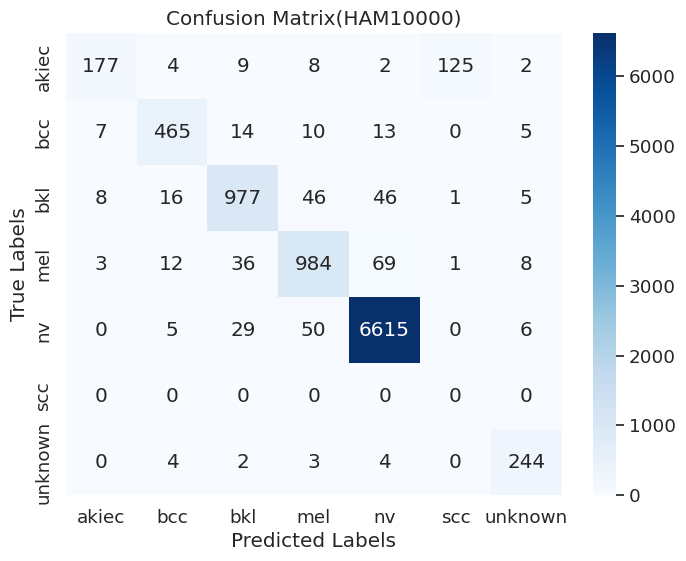


Multiclass Accuracy(HAM10000): 0.944782825761358
HAM10000 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.907692  0.541284  0.678161    327.000000
bcc            0.918972  0.904669  0.911765    514.000000
bkl            0.915651  0.888990  0.902124   1099.000000
mel            0.893733  0.884097  0.888889   1113.000000
nv             0.980145  0.986577  0.983351   6705.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.903704  0.949416  0.925996    257.000000
accuracy       0.944783  0.944783  0.944783      0.944783
macro avg      0.788557  0.736433  0.755755  10015.000000
weighted avg   0.955998  0.944783  0.948829  10015.000000

Multiclass ROC AUC Score(HAM10000): 0.9235396432843755


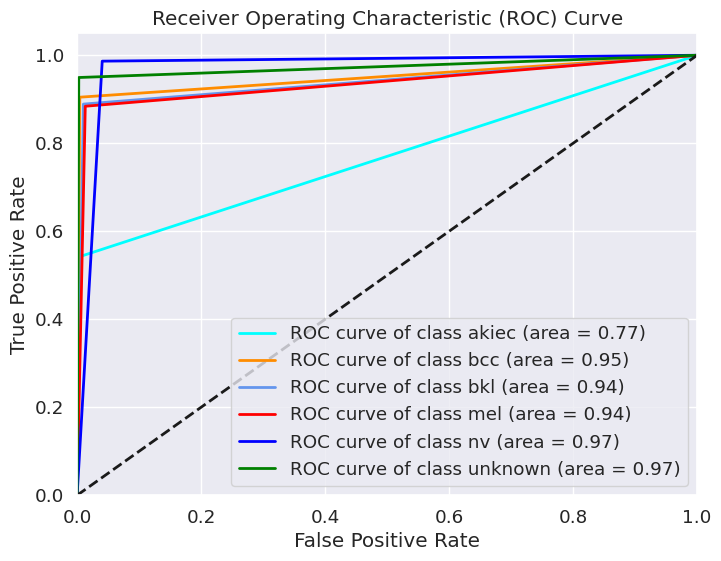

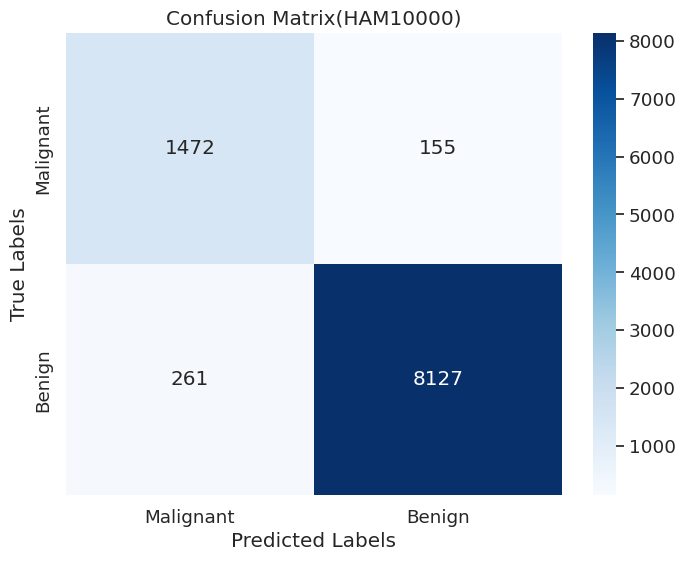


Binary Class Accuracy(HAM10000): 0.9584623065401897
HAM10000 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.849394  0.904733  0.876190   1627.000000
Benign         0.981285  0.968884  0.975045   8388.000000
accuracy       0.958462  0.958462  0.958462      0.958462
macro avg      0.915339  0.936808  0.925618  10015.000000
weighted avg   0.959858  0.958462  0.958985  10015.000000

Binary Class ROC AUC Score(HAM10000): 0.9368083784632185


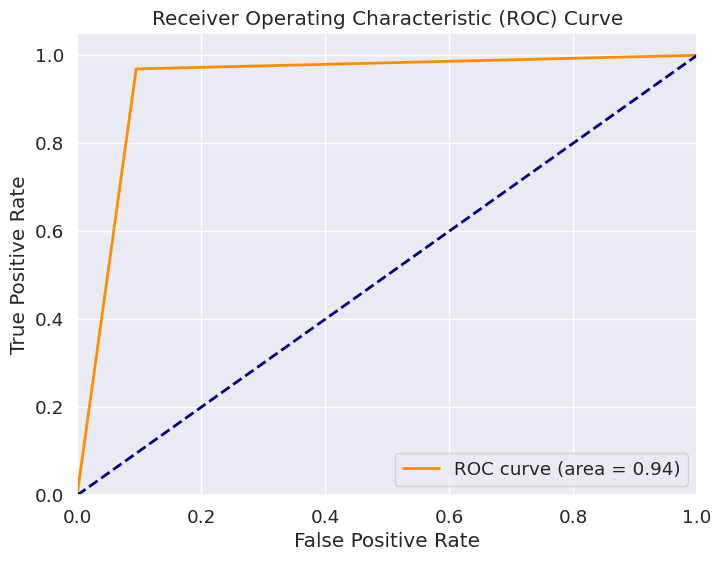

In [3]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/HAM10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    27124
nv          5193
mel          584
bkl          225
Name: count, dtype: int64
label
6    27124
4     5193
3      584
2      225
Name: count, dtype: int64
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


W0000 00:00:1714590825.635098     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


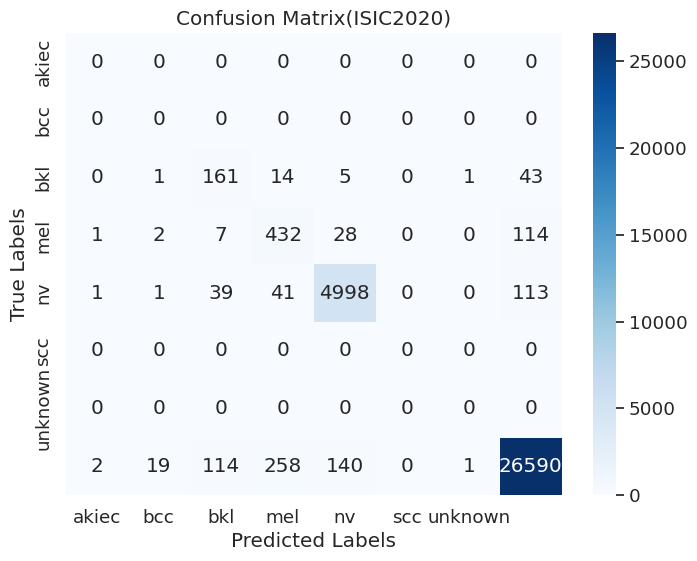


Multiclass Accuracy(ISIC2020): 0.9714725593189639
ISIC2020 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.000000  0.000000  0.000000      0.000000
bcc            0.000000  0.000000  0.000000      0.000000
bkl            0.501558  0.715556  0.589744    225.000000
mel            0.579866  0.739726  0.650113    584.000000
nv             0.966544  0.962449  0.964492   5193.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.989948  0.980313  0.985107  27124.000000
accuracy       0.971473  0.971473  0.971473      0.971473
macro avg      0.433988  0.485435  0.455637  33126.000000
weighted avg   0.975732  0.971473  0.973284  33126.000000

Multiclass ROC AUC Score(ISIC2020): 0.9165479828269949


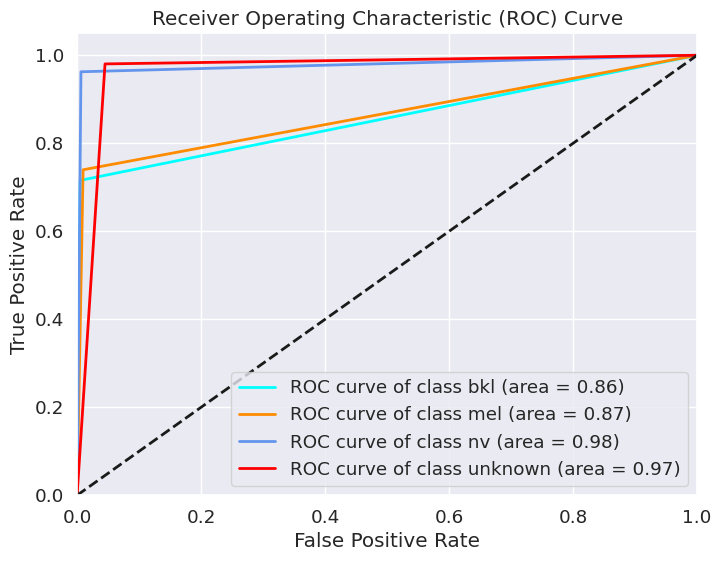

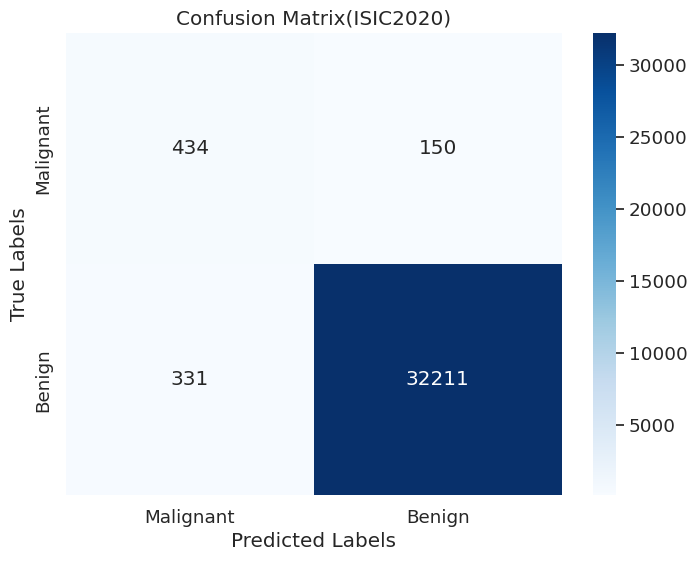


Binary Class Accuracy(ISIC2020): 0.9854796836321922
ISIC2020 Binary class Classification Report:
              precision    recall  f1-score      support
Malignant      0.567320  0.743151  0.643440    584.00000
Benign         0.995365  0.989829  0.992589  32542.00000
accuracy       0.985480  0.985480  0.985480      0.98548
macro avg      0.781343  0.866490  0.818014  33126.00000
weighted avg   0.987819  0.985480  0.986434  33126.00000

Binary Class ROC AUC Score(ISIC2020): 0.8664896071083691


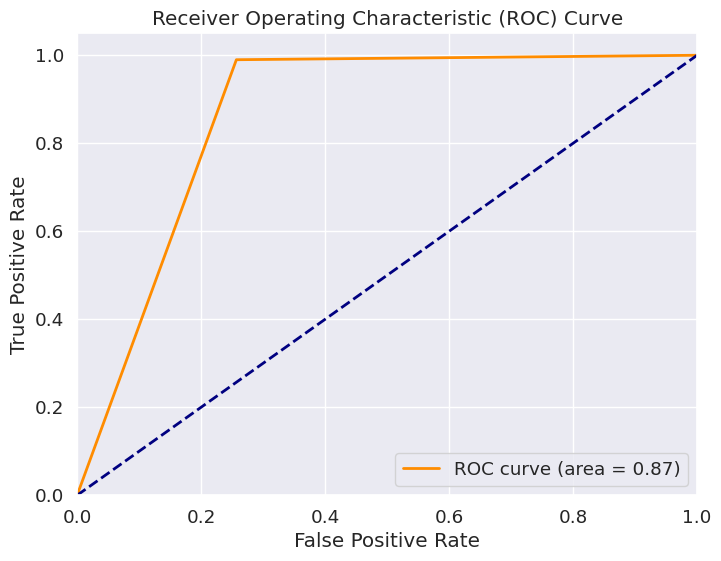

In [4]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         12875
mel         4522
bcc         3323
bkl         2624
akiec        867
scc          628
unknown      492
Name: count, dtype: int64
label
4    12875
3     4522
1     3323
2     2624
0      867
5      628
6      492
Name: count, dtype: int64
792/792 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


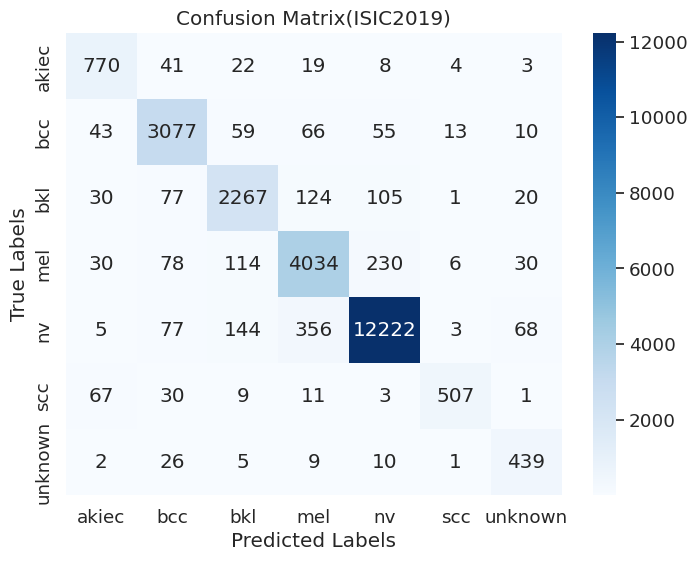


Multiclass Accuracy(ISIC2019): 0.9204531996368086
ISIC2019 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.813094  0.888120  0.848953    867.000000
bcc            0.903406  0.925971  0.914549   3323.000000
bkl            0.865267  0.863948  0.864607   2624.000000
mel            0.873349  0.892083  0.882617   4522.000000
nv             0.967466  0.949282  0.958288  12875.000000
scc            0.947664  0.807325  0.871883    628.000000
unknown        0.768827  0.892276  0.825964    492.000000
accuracy       0.920453  0.920453  0.920453      0.920453
macro avg      0.877010  0.888429  0.880980  25331.000000
weighted avg   0.922042  0.920453  0.920883  25331.000000

Multiclass ROC AUC Score(ISIC2019): 0.9366941307447944


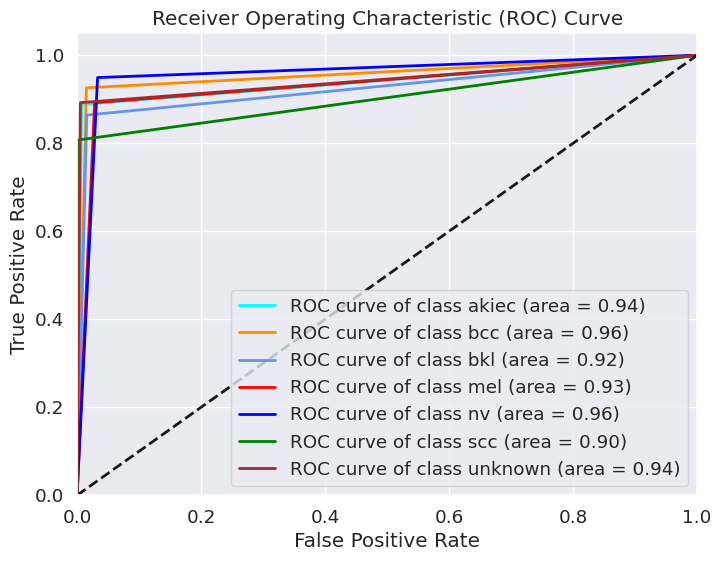

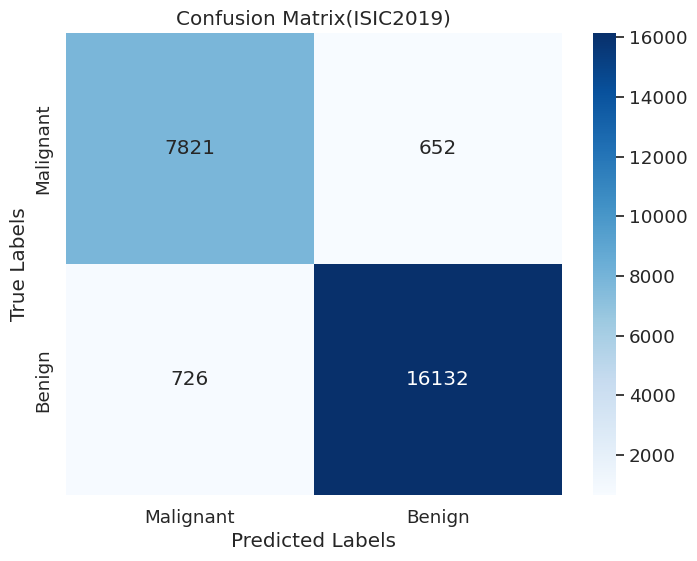


Binary Class Accuracy(ISIC2019): 0.9456002526548498
ISIC2019 Binary class Classification Report:
              precision    recall  f1-score     support
Malignant      0.915058  0.923050  0.919036   8473.0000
Benign         0.961153  0.956934  0.959039  16858.0000
accuracy       0.945600  0.945600  0.945600      0.9456
macro avg      0.938106  0.939992  0.939038  25331.0000
weighted avg   0.945735  0.945600  0.945659  25331.0000

Binary Class ROC AUC Score(ISIC2019): 0.9399920402041382


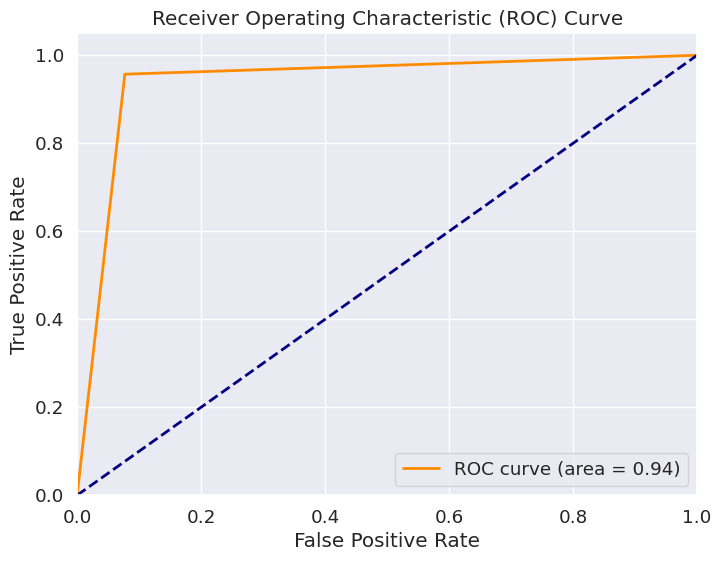

In [5]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

2140/2140 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step


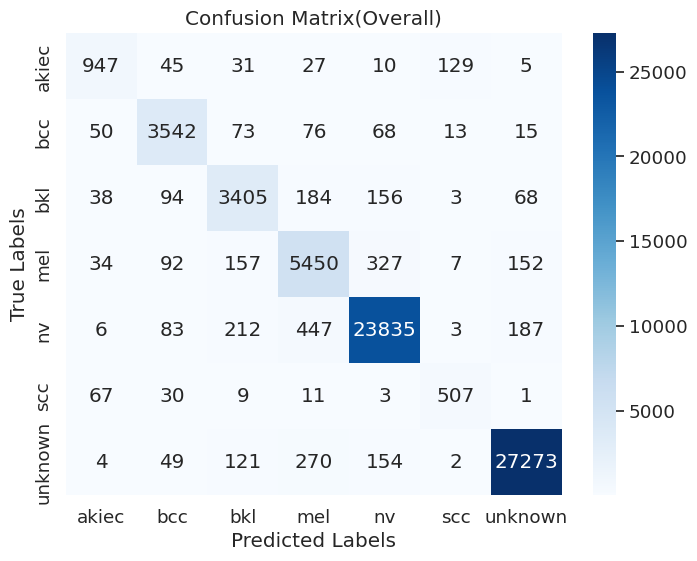


Multiclass Accuracy(Overall): 0.9486943568173852
Overall Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.826353  0.793132  0.809402   1194.000000
bcc            0.900127  0.923117  0.911477   3837.000000
bkl            0.849551  0.862462  0.855958   3948.000000
mel            0.843001  0.876347  0.859350   6219.000000
nv             0.970757  0.962136  0.966427  24773.000000
scc            0.763554  0.807325  0.784830    628.000000
unknown        0.984549  0.978474  0.981502  27873.000000
accuracy       0.948694  0.948694  0.948694      0.948694
macro avg      0.876842  0.886142  0.881278  68472.000000
weighted avg   0.949403  0.948694  0.948986  68472.000000

Multiclass ROC AUC Score(Overall): 0.9385012891025613


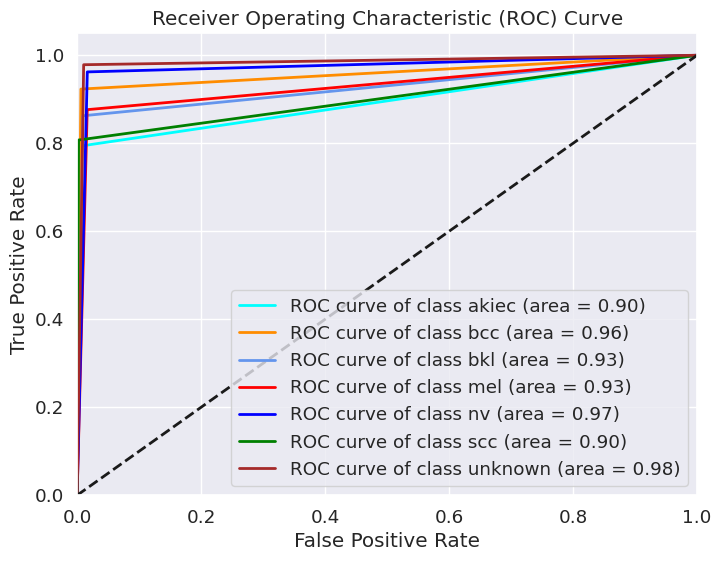

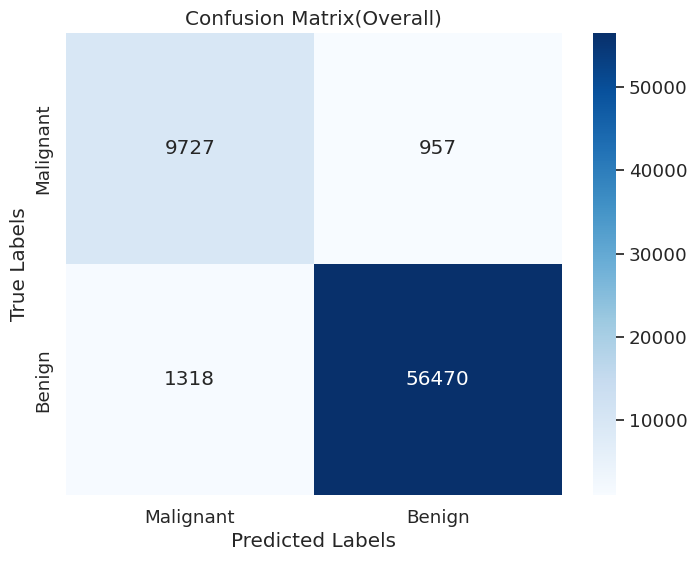


Binary Class Accuracy(Overall): 0.9667747400397243
Overall Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.880670  0.910427  0.895301  10684.000000
Benign         0.983335  0.977192  0.980254  57788.000000
accuracy       0.966775  0.966775  0.966775      0.966775
macro avg      0.932003  0.943810  0.937778  68472.000000
weighted avg   0.967316  0.966775  0.966999  68472.000000

Binary Class ROC AUC Score(Overall): 0.943809651575828


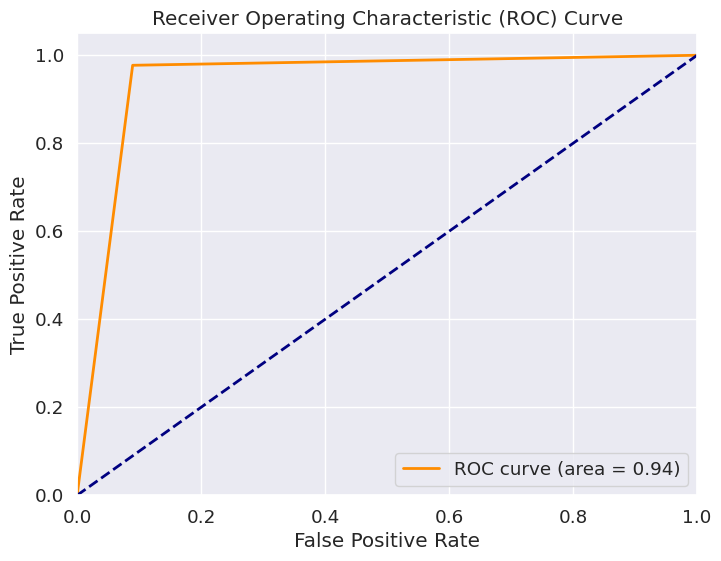

In [6]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         1340
mel         222
bkl         221
bcc         103
akiec        65
unknown      52
Name: count, dtype: int64
label
4    1340
3     222
2     221
1     103
0      65
6      52
Name: count, dtype: int64
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


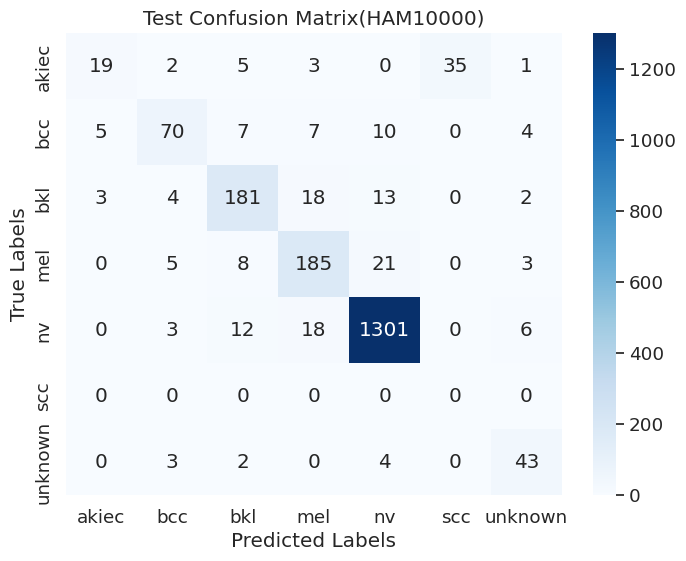


Multiclass Testing Accuracy(HAM10000): 0.8981527708437343
HAM10000 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.703704  0.292308  0.413043    65.000000
bcc            0.804598  0.679612  0.736842   103.000000
bkl            0.841860  0.819005  0.830275   221.000000
mel            0.800866  0.833333  0.816777   222.000000
nv             0.964418  0.970896  0.967646  1340.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.728814  0.826923  0.774775    52.000000
accuracy       0.898153  0.898153  0.898153     0.898153
macro avg      0.692037  0.631725  0.648480  2003.000000
weighted avg   0.909973  0.898153  0.900895  2003.000000

Multiclass Testing ROC AUC Score(HAM10000): 0.8569577900099699


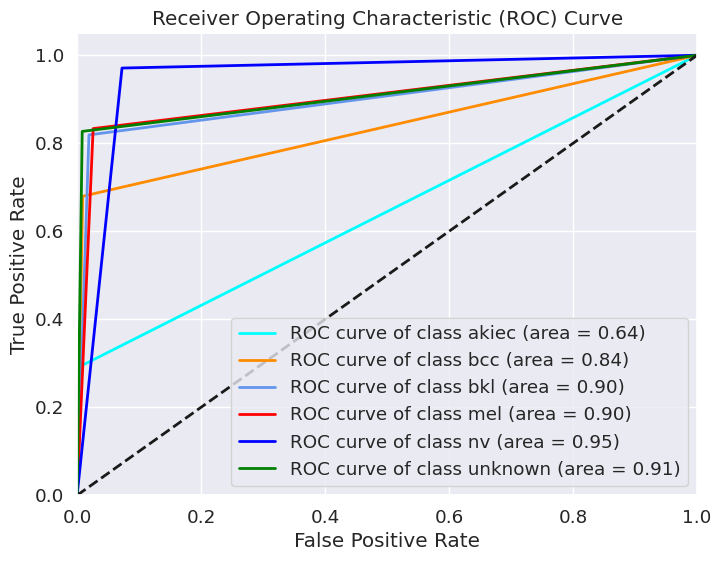

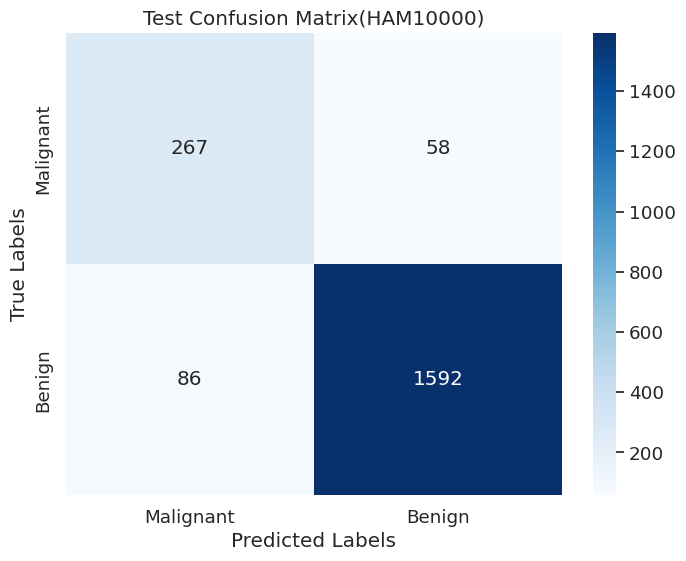


Binary Class Testing Accuracy(HAM10000): 0.9281078382426361
HAM10000 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.756374  0.821538  0.787611   325.000000
Benign         0.964848  0.948749  0.956731  1678.000000
accuracy       0.928108  0.928108  0.928108     0.928108
macro avg      0.860611  0.885143  0.872171  2003.000000
weighted avg   0.931022  0.928108  0.929290  2003.000000

Binary Class ROC AUC Score(HAM10000): 0.8851434858347851


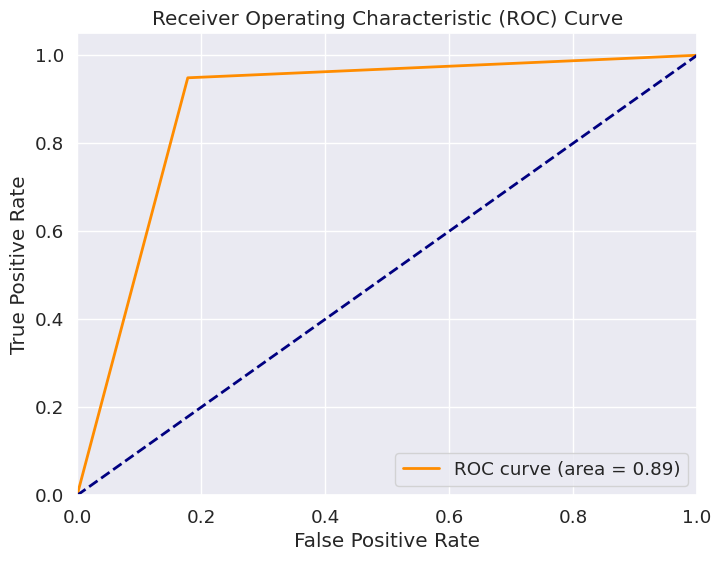

In [7]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/ham10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    5447
nv         1030
mel         105
bkl          44
Name: count, dtype: int64
label
6    5447
4    1030
3     105
2      44
Name: count, dtype: int64
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


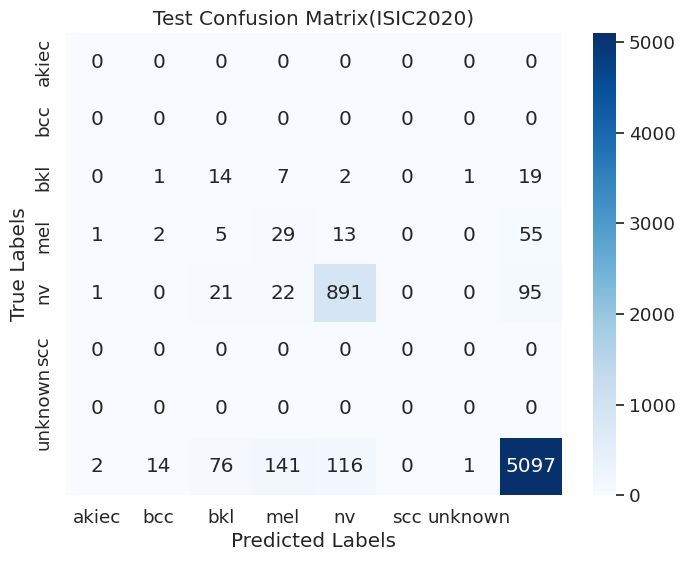


Multiclass Testing Accuracy(ISIC2020): 0.9102022336251132
ISIC2020 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.000000  0.000000  0.000000     0.000000
bcc            0.000000  0.000000  0.000000     0.000000
bkl            0.120690  0.318182  0.175000    44.000000
mel            0.145729  0.276190  0.190789   105.000000
nv             0.871820  0.865049  0.868421  1030.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.967907  0.935744  0.951554  5447.000000
accuracy       0.910202  0.910202  0.910202     0.910202
macro avg      0.300878  0.342166  0.312252  6626.000000
weighted avg   0.934316  0.910202  0.921419  6626.000000

Multiclass Testing ROC AUC Score(ISIC2020): 0.7733559325592556


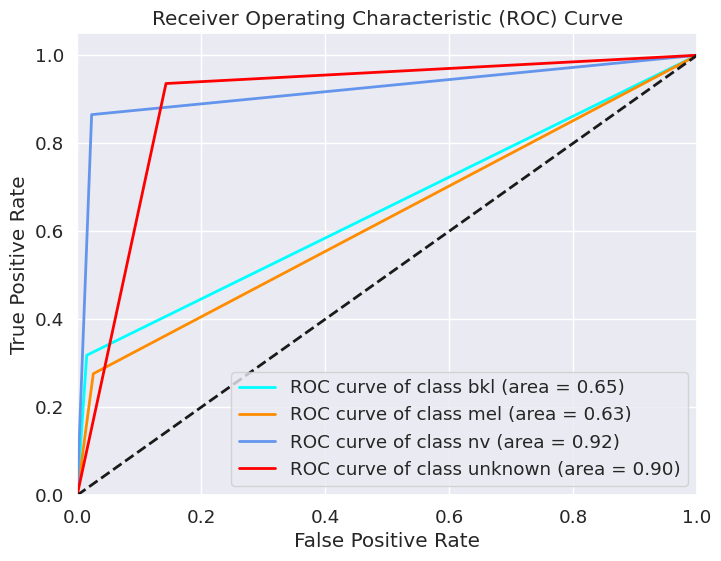

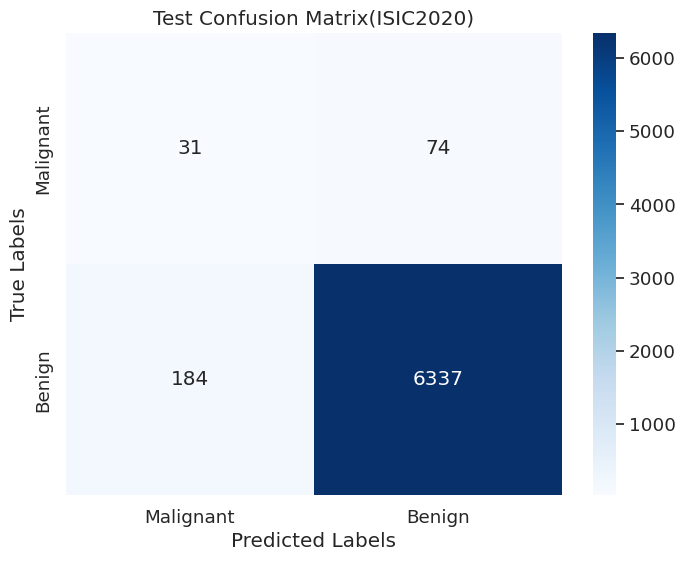


Binary Class Testing Accuracy(ISIC2020): 0.961062481134923
ISIC2020 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.144186  0.295238  0.193750   105.000000
Benign         0.988457  0.971783  0.980049  6521.000000
accuracy       0.961062  0.961062  0.961062     0.961062
macro avg      0.566322  0.633511  0.586900  6626.000000
weighted avg   0.975078  0.961062  0.967589  6626.000000

Binary Class ROC AUC Score(ISIC2020): 0.6335107820156125


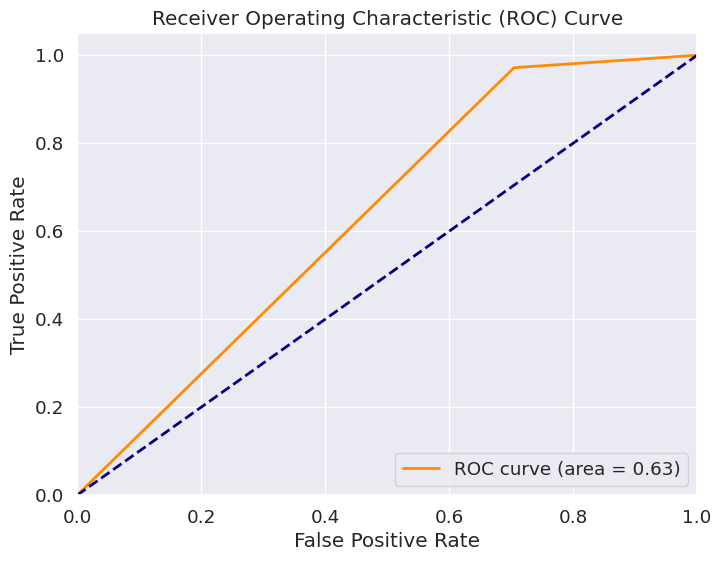

In [8]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         2622
mel         857
bcc         695
bkl         508
akiec       164
scc         128
unknown      93
Name: count, dtype: int64
label
4    2622
3     857
1     695
2     508
0     164
5     128
6      93
Name: count, dtype: int64
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


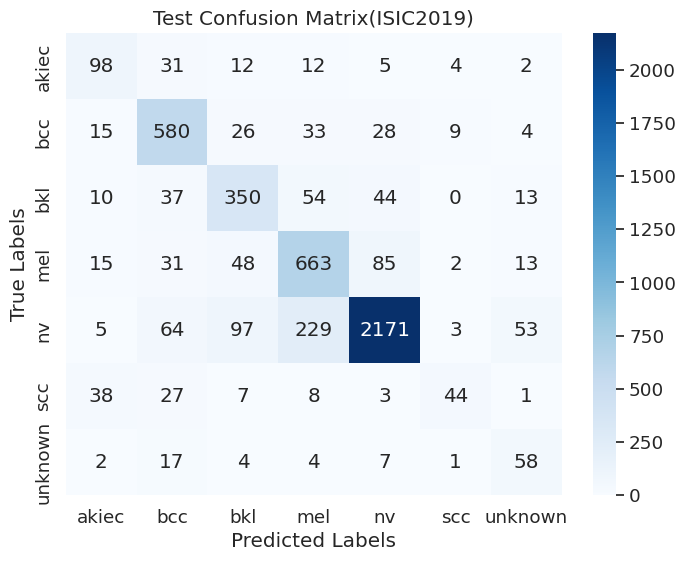


Multiclass Testing Accuracy(ISIC2019): 0.7823169528320505
ISIC2019 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.535519  0.597561  0.564841   164.000000
bcc            0.736976  0.834532  0.782726   695.000000
bkl            0.643382  0.688976  0.665399   508.000000
mel            0.661017  0.773629  0.712903   857.000000
nv             0.926590  0.827994  0.874522  2622.000000
scc            0.698413  0.343750  0.460733   128.000000
unknown        0.402778  0.623656  0.489451    93.000000
accuracy       0.782317  0.782317  0.782317     0.782317
macro avg      0.657811  0.670014  0.650082  5067.000000
weighted avg   0.799236  0.782317  0.786086  5067.000000

Multiclass Testing ROC AUC Score(ISIC2019): 0.8150441161406269


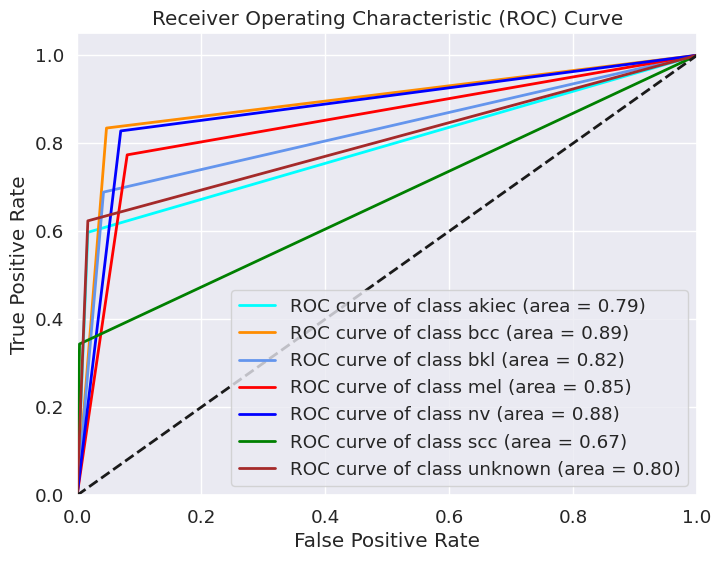

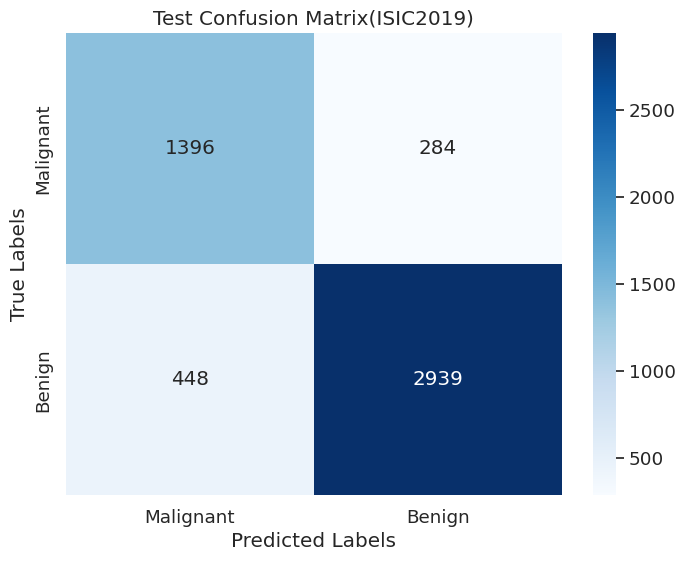


Binary Class Testing Accuracy(ISIC2019): 0.8555358200118414
ISIC2019 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.757050  0.830952  0.792281  1680.000000
Benign         0.911883  0.867730  0.889259  3387.000000
accuracy       0.855536  0.855536  0.855536     0.855536
macro avg      0.834467  0.849341  0.840770  5067.000000
weighted avg   0.860547  0.855536  0.857105  5067.000000

Binary Class ROC AUC Score(ISIC2019): 0.8493409675650596


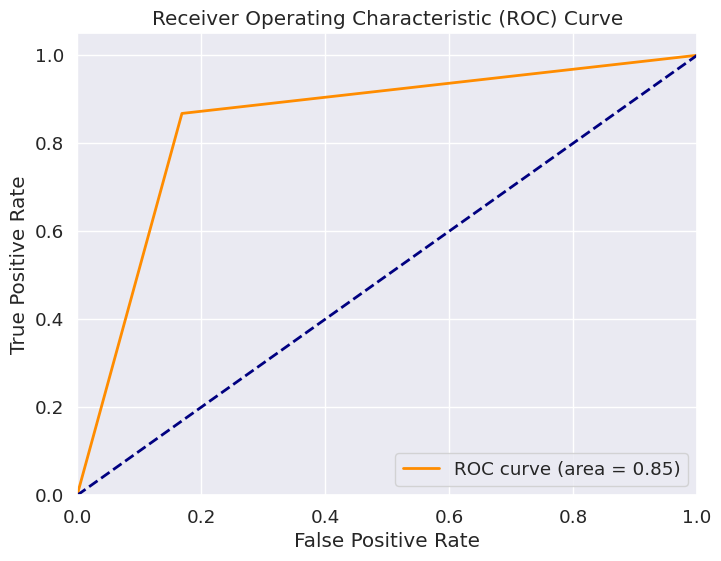

In [9]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


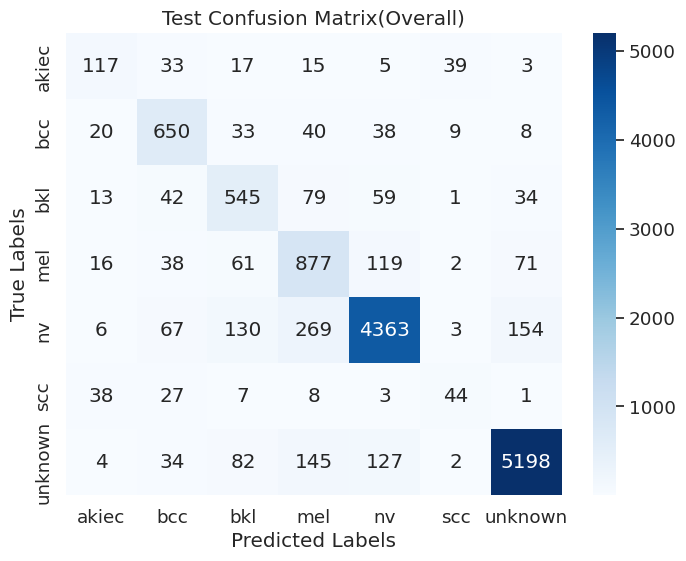


Multiclass Testing Accuracy(Overall): 0.8611273364485982
Overall Multiclass Test Classification Report():
              precision    recall  f1-score       support
akiec          0.546729  0.510917  0.528217    229.000000
bcc            0.729517  0.814536  0.769686    798.000000
bkl            0.622857  0.705045  0.661408    773.000000
mel            0.612003  0.740709  0.670233   1184.000000
nv             0.925541  0.873998  0.899032   4992.000000
scc            0.440000  0.343750  0.385965    128.000000
unknown        0.950448  0.929542  0.939879   5592.000000
accuracy       0.861127  0.861127  0.861127      0.861127
macro avg      0.689585  0.702643  0.693488  13696.000000
weighted avg   0.869229  0.861127  0.863987  13696.000000

Multiclass Testing ROC AUC Score(Overall): 0.8389102658597773


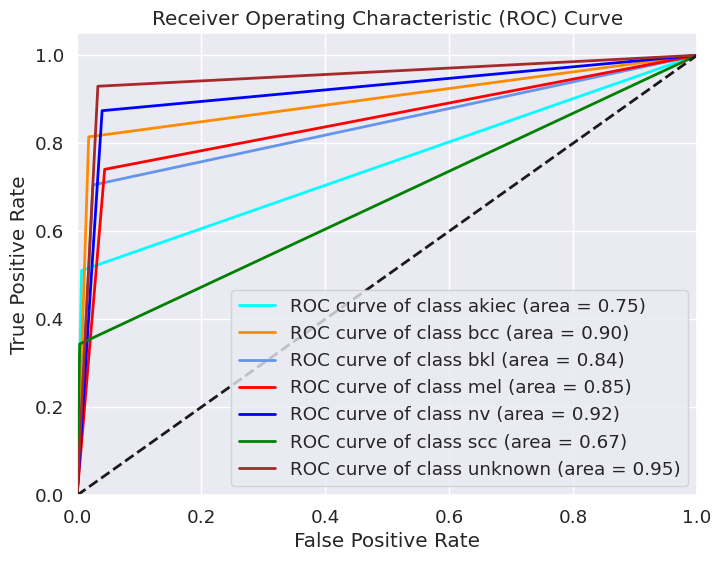

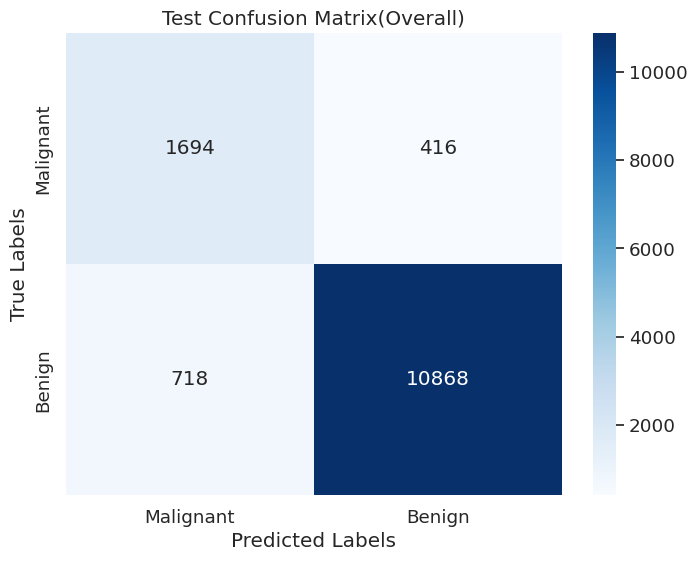


Binary Class Testing Accuracy(Overall): 0.9172021028037384
Overall Binary class Testing Classification Report:
              precision    recall  f1-score       support
Malignant      0.702322  0.802844  0.749226   2110.000000
Benign         0.963134  0.938029  0.950415  11586.000000
accuracy       0.917202  0.917202  0.917202      0.917202
macro avg      0.832728  0.870436  0.849821  13696.000000
weighted avg   0.922953  0.917202  0.919420  13696.000000

Binary Class ROC AUC Score(Overall): 0.8704361285846703


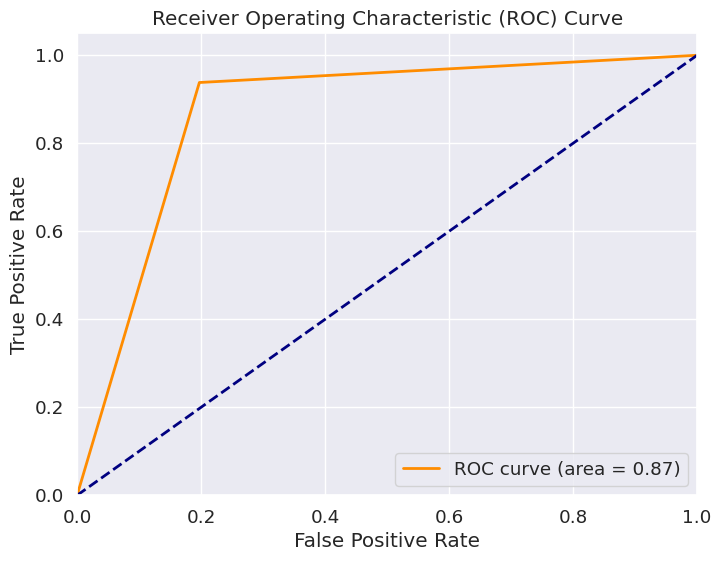

In [10]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()